On the sdf login node
```
[youtsumi@sdf-login02 u]$ source /cvmfs/sw.lsst.eu/linux-x86_64/lsst_distrib/w_2021_51/loadLSST.bash                                                                                                        [89/89]
(lsst-scipipe-0.7.0-ext) [youtsumi@sdf-login02 u]$ setup lsst_distrib
(lsst-scipipe-0.7.0-ext) [youtsumi@sdf-login02 u]$ jupyter lab
```

Needs an ssh tunnel in a separate window

In [1]:
! eups list -s lsst_distrib

   22.0.1-3-g7ae64ea+78f87bf5bb 	w_latest w_2021_51 current setup


In [2]:
import sys
sys.path.append("/sdf/group/lsst/camera/IandT/repo_gen3/spot_test_v2/u/youtsumi/202112/mixcoatl/python")

In [3]:
import numpy
import pylab as plt

# Stack imports
from lsst.daf.butler import Butler
import lsst.afw.display as afwDisplay
import lsst.meas.extensions.shapeHSM
import lsst.afw.image as afwImage
from lsst.ip.isr.isrTask import IsrTask
from mixcoatl.characterizeSpots import CharacterizeSpotsTask
from mixcoatl.gridFitTask import GridFitTask

/sdf/group/lsst/camera/IandT/repo_gen3/spot_test_v2/u/youtsumi/202112/mixcoatl/python/mixcoatl/characterizeSpots.py:136: FutureWarning: Call to deprecated function (or staticmethod) timeMethod. (timeMethod has been replaced by lsst.utils.timer.timeMethod. Will be removed after v25.) -- Deprecated since version v24.
  def run(self, exposure, exposureIdInfo=None):


In [4]:
def display(exposure,title=None):
    afwDisplay.setDefaultBackend('matplotlib') 
    fig = plt.figure(figsize=(10,10))
    afw_display = afwDisplay.Display(1)
    afw_display.scale('asinh', 'zscale')
    afw_display.mtv(exposure.getImage())
    plt.title(title)
    plt.gca().axis('off')

In [5]:
repo_path = "/sdf/group/lsst/camera/IandT/repo_gen3/BOT_data/"
butler = Butler(repo_path)

In [20]:
collections="LSSTCam/raw/all,u/youtsumi/Run5/run_R03_S12_dither/spot/20211225T200226Z".split(",")
butler = Butler(repo_path,collections=collections)
registry = butler.registry

In [21]:
print(registry)

PostgreSQL@rubin:bot_data_w_2021_43


In [22]:
butler = Butler(repo_path)
registry = butler.registry
for c in registry.queryCollections():
    print(c)    

LSSTCam/calib
LSSTCam/calib/unbounded
LSSTCam/raw/all
LSSTCam/photodiode/all
u/snyder18/crosstalk_13169/sbias
u/snyder18/crosstalk_13169/sbias/20211215T191900Z
u/snyder18/crosstalk_13169/calib
u/snyder18/crosstalk_13169/crosstalk_spot
u/snyder18/crosstalk_13175/sbias
u/snyder18/crosstalk_13175/sbias/20211217T211636Z
u/snyder18/crosstalk_13186/sbias
u/snyder18/crosstalk_13186/sbias/20211217T225138Z
u/snyder18/crosstalk_13175/calib
u/snyder18/crosstalk_13169/crosstalk_spot/20211218T003408Z
u/snyder18/crosstalk_13175/crosstalk_spot
u/snyder18/crosstalk_13186/calib
u/snyder18/crosstalk_13175/crosstalk_spot/20211218T225100Z
u/snyder18/crosstalk_13186/crosstalk_spot
u/snyder18/crosstalk_13186/crosstalk_spot/20211220T023605Z
u/snyder18/crosstalk_13198/sbias
u/snyder18/crosstalk_13198/sbias/20211220T182307Z
u/snyder18/crosstalk_13198/calib
u/snyder18/crosstalk_13200/sbias
u/snyder18/crosstalk_13200/sbias/20211220T215856Z
u/snyder18/crosstalk_13200/calib
u/snyder18/crosstalk_13200/crosstalk_spo

In [23]:
# then explore the inside of the collection
subbutler = Butler(repo_path,collections=collections)
subregistry = subbutler.registry
for dtype in subregistry.queryDatasetTypes():
    try:
        datasetRefs = list(subregistry.queryDatasets(datasetType=dtype,collections=collections))        
        print(len(datasetRefs), dtype )
    except:
        print("Error", dtype )

0 DatasetType('camera', {instrument}, Camera, isCalibration=True)
3142925 DatasetType('raw', {band, instrument, detector, physical_filter, exposure}, Exposure)
0 DatasetType('photodiode', {band, instrument, physical_filter, exposure}, AstropyTable)
0 DatasetType('cpBiasProc', {band, instrument, detector, physical_filter, exposure}, Exposure)
2498 DatasetType('isr_metadata', {band, instrument, detector, physical_filter, exposure}, PropertySet)
0 DatasetType('bias', {instrument, detector}, ExposureF, isCalibration=True)
0 DatasetType('cpCombine_metadata', {instrument, detector}, PropertySet)
1 DatasetType('isr_config', {}, Config)
0 DatasetType('cpCombine_config', {}, Config)
1 DatasetType('packages', {}, Packages)
0 DatasetType('cpCrosstalkProc', {band, instrument, detector, physical_filter, exposure}, Exposure)
0 DatasetType('crosstalkBackgroundZOffsets', {band, instrument, detector, physical_filter, exposure}, StructuredDataDict)
0 DatasetType('crosstalkBackgroundYTilts', {band, instr

In [24]:
where = """
instrument='LSSTCam'
and detector=23
"""
#and exposure.observation_type = 'spot'
#and exposure.science_program IN ('13232','13234')

datasetRefs = list(subregistry.queryDatasets(
    datasetType="gridSpotSrc",
    collections=collections,
    where=where)
                  )
results = []

for aref in datasetRefs[-100:]:
    try:
        # get a catalog from the butler
        src = subbutler.get(aref)
        # get the associated metadata from raw data which contains EXPTIME
        raw = subbutler.get("raw",dataId=aref.dataId)
        img = raw.getImage().getArray()
        md = raw.getMetadata()
        # stores into memory for later use
        results.append( {"md": md, "src":src} )
    except:
        raise
        pass

/sdf/group/lsst/camera/IandT/rawData/focal-plane/20211223/MC_C_20211223_000608/MC_C_20211223_000608_R03_S12.fits(MC_C_20211223_000608): Unable to determine the filter
/sdf/group/lsst/camera/IandT/rawData/focal-plane/20211223/MC_C_20211223_000608/MC_C_20211223_000608_R03_S12.fits: outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))
/sdf/group/lsst/camera/IandT/rawData/focal-plane/20211223/MC_C_20211223_001161/MC_C_20211223_001161_R03_S12.fits(MC_C_20211223_001161): Unable to determine the filter
/sdf/group/lsst/camera/IandT/rawData/focal-plane/20211223/MC_C_20211223_001161/MC_C_20211223_001161_R03_S12.fits: outAmp.getRawBBox() != data.getBBox(); patching. ((minimum=(0, 0), maximum=(543, 2047)) v. (minimum=(0, 0), maximum=(575, 2047)))
/sdf/group/lsst/camera/IandT/rawData/focal-plane/20211223/MC_C_20211223_002038/MC_C_20211223_002038_R03_S12.fits(MC_C_20211223_002038): Unable to determine the filter
/sdf/group/

In [40]:
subbutler.get(datasetRefs[0]).asAstropy().colnames

['id',
 'coord_ra',
 'coord_dec',
 'parent',
 'base_SdssCentroid_x',
 'base_SdssCentroid_y',
 'base_SdssCentroid_xErr',
 'base_SdssCentroid_yErr',
 'base_SdssCentroid_flag',
 'base_SdssCentroid_flag_edge',
 'base_SdssCentroid_flag_noSecondDerivative',
 'base_SdssCentroid_flag_almostNoSecondDerivative',
 'base_SdssCentroid_flag_notAtMaximum',
 'base_SdssCentroid_flag_resetToPeak',
 'base_SdssCentroid_flag_badError',
 'base_SdssShape_xx',
 'base_SdssShape_yy',
 'base_SdssShape_xy',
 'base_SdssShape_xxErr',
 'base_SdssShape_yyErr',
 'base_SdssShape_xyErr',
 'base_SdssShape_x',
 'base_SdssShape_y',
 'base_SdssShape_instFlux',
 'base_SdssShape_instFluxErr',
 'base_SdssShape_psf_xx',
 'base_SdssShape_psf_yy',
 'base_SdssShape_psf_xy',
 'base_SdssShape_instFlux_xx_Cov',
 'base_SdssShape_instFlux_yy_Cov',
 'base_SdssShape_instFlux_xy_Cov',
 'base_SdssShape_flag',
 'base_SdssShape_flag_unweightedBad',
 'base_SdssShape_flag_unweighted',
 'base_SdssShape_flag_shift',
 'base_SdssShape_flag_maxIter

<AxesSubplot:xlabel='base_PsfFlux_instFlux', ylabel='base_CircularApertureFlux_70_0_instFlux'>

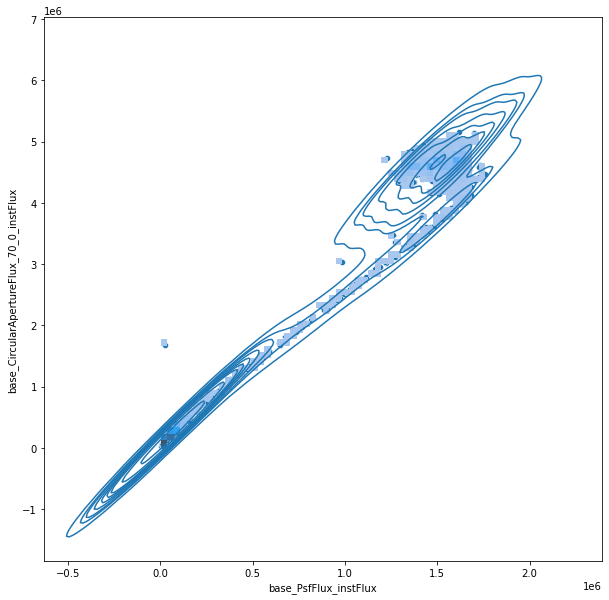

In [46]:
subbutler.get(datasetRefs[0]).asAstropy().colnames
acat=subbutler.get(datasetRefs[0]).asAstropy()
# base_PsfFlux_instFlux
# base_CircularApertureFlux_70_0_instFlux
import seaborn as sns
f, ax = plt.subplots(figsize=(10, 10))
sns.scatterplot(x=acat["base_PsfFlux_instFlux"],y=acat["base_CircularApertureFlux_70_0_instFlux"])
sns.histplot(x=acat["base_PsfFlux_instFlux"],y=acat["base_CircularApertureFlux_70_0_instFlux"],bins=50)
sns.kdeplot(x=acat["base_PsfFlux_instFlux"],y=acat["base_CircularApertureFlux_70_0_instFlux"])

Text(0, 0.5, 'ext_shapeHSM_HsmSourceMoments_xx+ext_shapeHSM_HsmSourceMoments_yy')

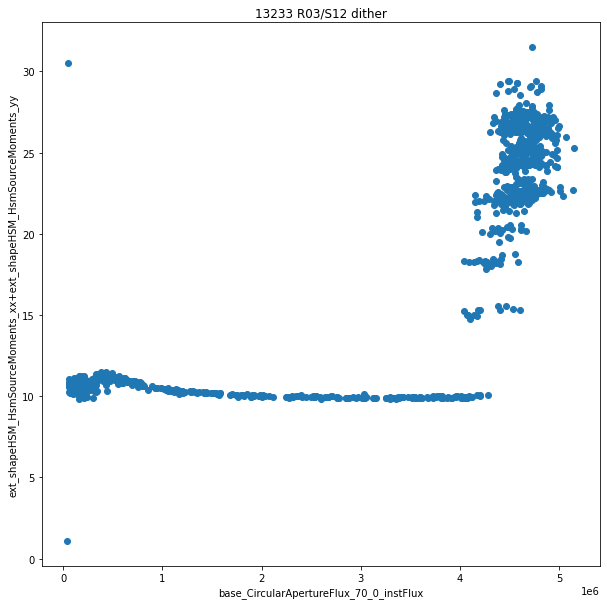

In [50]:
f, ax = plt.subplots(figsize=(10, 10),facecolor="white")

pylab.scatter(acat["base_CircularApertureFlux_70_0_instFlux"], acat["ext_shapeHSM_HsmSourceMoments_xx"]+acat["ext_shapeHSM_HsmSourceMoments_yy"])
pylab.title("13233 R03/S12 dither")
pylab.xlabel("base_CircularApertureFlux_70_0_instFlux")
pylab.ylabel("ext_shapeHSM_HsmSourceMoments_xx+ext_shapeHSM_HsmSourceMoments_yy")